In [1]:
import pandas as pd
import chardet
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import abline_plot
import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
from numpy import random
from sklearn.linear_model import LinearRegression, Lasso, Ridge


%matplotlib inline
rndseed = 12345

In [2]:
# plotting function
# plots five features and the label separately (dataframe.name must be assigned before calling this function)
# param: the source dataframe
# return: none
def plot_five_features(source):
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,10))
    fig.suptitle(source.name)
    ls = [ax[0,0], ax[0,1], ax[1,0], ax[1,1], ax[2,0]]
    for i in range(5):
        x_temp = source[list(source)[i+1]]
        x_label = data_dict[feature_dict[i+1]]
        data = pd.DataFrame(); data['y'] = source.y; data['x'] = x_temp
        ls[i].scatter(y=source.y, x=x_temp)
        model_temp = smf.ols(formula='y ~ x', data=data).fit()
        abline_plot(model_results=model_temp, ax=ls[i], color='red')
        ls[i].set_xlabel( x_label + ' ' + feature_dict[i+1].split(' ')[1])
        ls[i].set_ylabel('CO2 emission (g/km)')
        ls[i].set_title('CO2 emission VS ' + x_label)
    ax[2,1].remove()
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [3]:
# Cross Validation
# print the cross validation result after n runs
# param: data(must have a y column), 
#         n(number of iterations)
# returns: none
def cross_validation(data, n):
    np.random.seed(rndseed)
    R_IS=[]; R_OS=[]
    for i in range(n):
        Xtrain, Xtest, ytrain, ytest = train_test_split(data.drop('y', axis=1), data.y, test_size=0.3)# 2/3 train and 1/3 test
    #     print(len(Xtrain), len(Xtest), len(ytrain), len(ytest))
        res=LinearRegression(fit_intercept=False)
        res.fit(Xtrain,ytrain)
    #     R_IS.append(1-((np.asarray(res.predict(Xtrain))-ytrain)**2).sum()/((ytrain-np.mean(ytrain))**2).sum())                                                                     
    #     R_OS.append(1-((np.asarray(res.predict(Xtest))-ytest)**2).sum()/((ytest-np.mean(ytest))**2).sum())
        R_IS.append(res.score(Xtrain, ytrain))
        R_OS.append(res.score(Xtest, ytest))
    print("IS R-squared for %d times is %.10f+-%.3f"%(n,np.mean(R_IS),np.std(R_IS)))
    print("OS R-squared for %d times is %.10f+-%.3f"%(n,np.mean(R_OS),np.std(R_OS)))

In [4]:
# cross validation for optimazing hyper parameters for regularization
# param:  func: the modeling function
#         x, y: data
#         alphas: a list of alpha values to try
# return:
#         optimal lambda and the corresponding os r squared values

'''
Ridge: alpha/lambda is the penalty for features. The shrinkage penalty is lambda times the sum of 
    squares of the coefficients so coefficients that get too large are penalized. 
    As lambda gets larger, the bias is unchanged but the variance drops.
        if lambda == 0, ridge = simple linear

Lasso: the penalty is the sum of the absolute values of the coefficients
    When lambda is small, the result is essentially the least squares estimates. 
    As lambda increases, shrinkage occurs so that variables that are at zero can be thrown away. 
    So, a major advantage of lasso is that it is a combination of both shrinkage and selection of variables. 
    In cases with very large number of features, lasso allow us to efficiently find the sparse model that involve a small subset of the features.
        if lambda == 0, lasso = simple linear
'''
def optimal_alpha(func, x, y, alphas):
#     np.random.seed(rndseed)
    Xtrain, Xvalid, ytrain, yvalid = train_test_split(x, y, test_size=0.4)
    R_OS=[]
    bestR2 = -1
    bestAlpha = alphas[0]
    for a in alphas:
        model = func(alpha=a)
        model.fit(Xtrain, ytrain)
        ypredict = model.predict(Xvalid)
#         os_r2 = abs(model.score(Xvalid, yvalid))
        
        err_OS = ypredict - yvalid
        os_r2 = 1-np.var(err_OS)/np.var(yvalid)
        R_OS.append(os_r2)
        
        R_OS.append(os_r2)
        if os_r2 > bestR2:
            bestR2 = os_r2
            bestAlpha = a
    print(max(R_OS))
    return bestAlpha
        

## Read and clean data

In [5]:
# the file is from the eu, and is not utf-8 encoded
with open('data/CO2_passenger_cars_v14.csv', 'rb') as f:
    result = chardet.detect(f.read())
result['encoding']

'UTF-16'

In [6]:
# read csv file into dataframe, skip the last three columns, which are mostly nan values
data = pd.read_csv('data/CO2_passenger_cars_v14.csv', sep='\t', encoding=result['encoding'], usecols=range(23))

In [7]:
# a list of column names that would need to be converted to numerical values for analysis
num_col = ['m (kg)','e (g/km)','w (mm)','at1 (mm)','at2 (mm)','Ft','Fm','ec (cm3)','TAN','ep (KW)']

In [8]:
# convert to numeric values
for c in num_col:
    pd.to_numeric(data[c], 'coerce')

In [9]:
data.dropna(inplace=True)

In [10]:
data.columns

Index(['id', 'MS', 'MP', 'Mh', 'Man', 'MMS', 'TAN', 'T', 'Va', 'Ve', 'Mk',
       'Cn', 'Ct', 'r', 'e (g/km)', 'm (kg)', 'w (mm)', 'at1 (mm)', 'at2 (mm)',
       'Ft', 'Fm', 'ec (cm3)', 'ep (KW)'],
      dtype='object')

In [11]:
# a dictionary of coulmn names and their explanations
data_dict = {'MS':'Member state',
'MP':'Manufacturer pooling',
'Mh':'Manufacturer harmonised',
'MAN':'Manufacturer name OEM declaration',
'MMS':'Manufacturer name as in MS registry',
'T':'Type',
'Va':'Variant',
'Ve':'Version',
'Mk':'Make',
'Cn':'Commercial name',
'Ct':'Category of the vehicle type approved',
'r':'Total new registrations',
'm (kg)':'Mass',
'e (g/km)':'Specific CO2 Emissions',
'w (mm)':'Wheel Base',
'at1 (mm)':'Axle width steering axle',
'at2 (mm)':'Axle width other axle',
'Ft':'Fuel type',
'Fm':'Fuel mode',
'ec (cm3)':'Engine capacity',
'TAN':'Type approval number',
'ep (KW)':'Engine power'}

feature_dict = ['e (g/km)',
'w (mm)',
'at1 (mm)',
'at2 (mm)',
'ec (cm3)',
'ep (KW)']

In [14]:
# convert variables to categorical values


## The label is the co2 emission, now find the features
    1. continuous features
    2. categorical features

In [12]:
# pick a few features for a simple multivariate linear regression

mulr = pd.DataFrame()
mulr['y'] = data['e (g/km)']
mulr['x1'] = data['w (mm)']
mulr['x2'] = data['at1 (mm)']
mulr['x3'] = data['at2 (mm)']
mulr['x4'] = data['ec (cm3)']
mulr['x5'] = data['ep (KW)']

In [13]:
# drop outlier
#mulr.drop(mulr[mulr.x3 == mulr.x3.max()].index, inplace = True)

## Play with lasso and ridge

In [16]:
# lasso model
scaler = preprocessing.StandardScaler().fit(mulr)
scaled_data = scaler.transform(mulr)
y = scaled_data[:, 0]
X = scaled_data[:,1:]

# 10 iterations and find the average
ls = []
for i in range(10):
#     np.random.seed(rndseed)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)# 2/3 train and 1/3 test
    k = optimal_alpha(Lasso, Xtrain, ytrain, alphas=np.exp(np.linspace(-5,6.5,200))) # lasso uses exp lambda
    ls.append(k)
ls

0.565526145728265
0.5650254513833237
0.5638458546486373
0.5614098531293492
0.5649374779619643
0.5704920397576925
0.5628413311114941
0.5697940684686298
0.5627543516099452
0.5652237017419359


[0.006737946999085467,
 0.006737946999085467,
 0.006737946999085467,
 0.006737946999085467,
 0.006737946999085467,
 0.006737946999085467,
 0.006737946999085467,
 0.006737946999085467,
 0.006737946999085467,
 0.006737946999085467]

In [17]:
# Ridge model
# 10 iterations and find the average
ls = []
for i in range(10):
#     np.random.seed(rndseed)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)# 2/3 train and 1/3 test
    k = optimal_alpha(Ridge, Xtrain, ytrain, alphas = np.exp(np.linspace(0,13,200))) # ridge must use exp alpha
    ls.append(k)
ls

0.5658597164727461
0.5585957435893337
0.560944124561586
0.5644192560200869
0.5659149264053891
0.5548431675923235
0.5645337902334564
0.561297566332708
0.5584357619978533
0.5540672301930538


[7705.955448140163,
 10007.151600107905,
 8781.495566998592,
 1.0,
 186.07143391058517,
 9374.313703660147,
 1.0,
 8226.166397984642,
 8781.495566998592,
 10682.71089631252]

In [26]:
# lasso coefs
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
model = Lasso(alpha=optimal_alpha(Lasso, Xtrain, ytrain, alphas=np.exp(np.linspace(-5,6.5,200))))
model.fit(Xtrain, ytrain)
model.coef_

0.5568855098653456


array([0.12021092, 0.06119836, 0.05510817, 0.11201821, 0.49534587])

In [27]:
# lasso coef after pca
# PCA
pca = PCA(5) # n_components = min(n_samples, n_features)
P = pca.fit_transform(X)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
model = Lasso(alpha=optimal_alpha(Lasso, Xtrain, ytrain, alphas=np.exp(np.linspace(-5,6.5,200))))
model.fit(Xtrain, ytrain)
model.coef_

0.5537665165673771


array([0.11175609, 0.0654011 , 0.05343214, 0.11062722, 0.49006958])

In [28]:
# ridge coefs
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
model = Ridge(alpha=optimal_alpha(Ridge, Xtrain, ytrain, alphas=np.exp(np.linspace(0,13,200))))
model.fit(Xtrain, ytrain)
model.coef_

0.5643603136464521


array([ 0.11854807, -0.02117763,  0.17570536,  0.10813437,  0.50183853])

In [29]:
# ridge coef after pca
# PCA
pca = PCA(5) # n_components = min(n_samples, n_features)
P = pca.fit_transform(X)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
model = Ridge(alpha=optimal_alpha(Ridge, Xtrain, ytrain, alphas=np.exp(np.linspace(0,13,200))))
model.fit(Xtrain, ytrain)
model.coef_

0.5670350621336893


array([ 0.11740763, -0.02194147,  0.17853853,  0.10474018,  0.50334029])

# FIT A LINE with ols formula

In [14]:
model = smf.ols(formula='y ~ x1 + x2 + x3 + x4 + x5', data=mulr).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.566
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                 8.558e+04
Date:                Sun, 11 Nov 2018   Prob (F-statistic):               0.00
Time:                        15:21:04   Log-Likelihood:            -1.4300e+06
No. Observations:              327510   AIC:                         2.860e+06
Df Residuals:                  327504   BIC:                         2.860e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -55.2879      1.168    -47.340      0.000     -57.577     -52.999
x1             0.0177      0.000     67.977      0.000       0.017       0.018
x2             0.0278      0.001     20.210      0.000       0.025       0.030
x3             0.0332      0.001     32.321      0.000       0.031       0.035
x4             0.0052      0.000     42.749      0.000       0.005       0.005
x5             0.2714      0.001    211.782      0.000       0.269       0.274
==============================================================================
Omnibus:                    42538.172   Durbin-Watson:                   0.492
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           538686.295
Skew:                           0.052   Prob(JB):                         0.00
Kurtosis:                       9.282   Cond. No.                     1.39e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
model.pvalues

Intercept     0.000000e+00
x1            0.000000e+00
x2            9.171491e-91
x3           8.280241e-229
x4            0.000000e+00
x5            0.000000e+00
dtype: float64

# P-values are all zeros,  whats going on

In [16]:
cross_validation(mulr, 100)

IS R-squared for 100 times is 0.5638935512+-0.001
OS R-squared for 100 times is 0.5601761726+-0.005


In [17]:
mulr.corr()

,y,x1,x2,x3,x4,x5
y,1.000000,0.465581,0.542031,0.523604,0.688017,0.714910
x1,0.465581,1.000000,0.782959,0.718128,0.479334,0.371319
x2,0.542031,0.782959,1.000000,0.866840,0.585750,0.508713
x3,0.523604,0.718128,0.866840,1.000000,0.558777,0.488826
x4,0.688017,0.479334,0.585750,0.558777,1.000000,0.874125
x5,0.714910,0.371319,0.508713,0.488826,0.874125,1.000000


## Performance
- the model performs equally well in and out of the sample
- there appears to be no issues of over fitting
- but the ols summary suggests that there might be strong colinearity
        - PCA!

## PCA

In [18]:
# Standarize to zero mean and unit variance
scaler = preprocessing.StandardScaler().fit(mulr)
scaled_data = scaler.transform(mulr)
y = scaled_data[:, 0]
X = scaled_data[:,1:]

In [19]:
# PCA
pca = PCA(5) # n_components = min(n_samples, n_features)
P = pca.fit_transform(X)
eigenvalues = pca.explained_variance_ratio_
print(eigenvalues, pca.components_, pca.explained_variance_, pca.n_components_)

[0.70095223 0.1933497  0.05763975 0.02467845 0.02337987] [[ 0.43042585  0.48297868  0.46876008  0.44217028  0.40769426]
 [ 0.4289277   0.30475026  0.30237878 -0.50531703 -0.61349008]
 [-0.75988887  0.24279716  0.58591859 -0.14246847 -0.00453762]
 [ 0.16448888 -0.76436893  0.57597662  0.19324048 -0.13997356]
 [ 0.16207077 -0.17506727  0.11739419 -0.70107132  0.66166618]] [3.50477183 0.96675147 0.28819961 0.12339264 0.11689971] 5


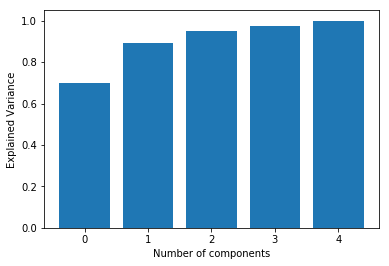

In [20]:
# plot explained variance
n=P.shape[1]
plt.bar(np.arange(n), eigenvalues.cumsum()/eigenvalues.sum(),align='center');
plt.xlabel("Number of components")
plt.ylabel("Explained Variance")
plt.show()

In [55]:
df = pd.DataFrame(data=P[:,0:3], index=P[:,3])
k = df[0].max()
df.drop(df[df[0]==k].index, axis=0, inplace=True)

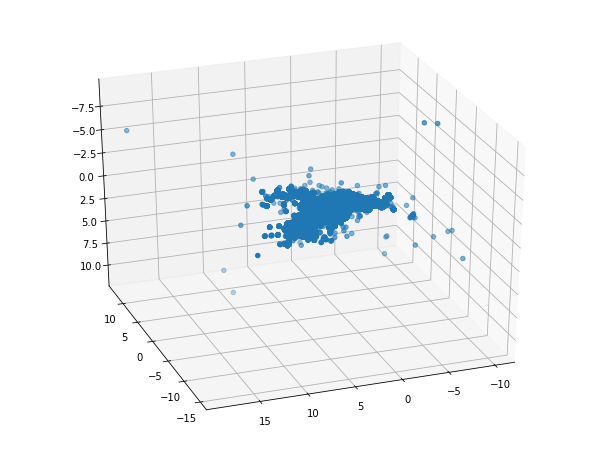

In [58]:
# plot dedemontionalized data
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
ax.scatter(df[0], df[1], df.index)

In [59]:
ax.scatter(df[0], df.index)

In [65]:
PCA_data = pd.DataFrame()
PCA_data['y'] = y;PCA_data['x1'] = X[:, 0];PCA_data['x2'] = X[:, 1];PCA_data['x3'] = X[:, 2];PCA_data['x4'] = X[:, 3];PCA_data['x5'] = X[:, 4]
PCA_data.corr()

,y,x1,x2,x3,x4,x5
y,1.000000,0.465581,0.542031,0.523604,0.688017,0.714910
x1,0.465581,1.000000,0.782959,0.718128,0.479334,0.371319
x2,0.542031,0.782959,1.000000,0.866840,0.585750,0.508713
x3,0.523604,0.718128,0.866840,1.000000,0.558777,0.488826
x4,0.688017,0.479334,0.585750,0.558777,1.000000,0.874125
x5,0.714910,0.371319,0.508713,0.488826,0.874125,1.000000


In [22]:
pca_model = smf.ols(formula='y ~ x1 + x2 + x3 + x4 + x5', data=PCA_data).fit()
pca_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                 5.419e+04
Date:                Fri, 09 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:46:57   Log-Likelihood:            -3.6600e+05
No. Observations:              327510   AIC:                         7.320e+05
Df Residuals:                  327504   BIC:                         7.321e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2.503e-14      0.001   1.94e-11      1.000      -0.003       0.003
x1             0.0838      0.002     38.387      0.000       0.080       0.088
x2            -0.0405      0.004    -10.917      0.000      -0.048      -0.033
x3             0.2050      0.004     55.843      0.000       0.198       0.212
x4             0.0682      0.003     26.869      0.000       0.063       0.073
x5             0.4415      0.002    181.477      0.000       0.437       0.446
==============================================================================
Omnibus:                   132046.640   Durbin-Watson:                   0.504
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2052120.871
Skew:                          -1.526   Prob(JB):                         0.00
Kurtosis:                      14.877   Cond. No.                         7.38
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
cross_validation(PCA_data, 100)

IS R-squared for 100 times is 0.4527246609+-0.001
OS R-squared for 100 times is 0.4526770035+-0.003


## Nonlinearity
- from the plots, it appears that x2 and x3 are not described very well by the line
- try to raise the features to their squares

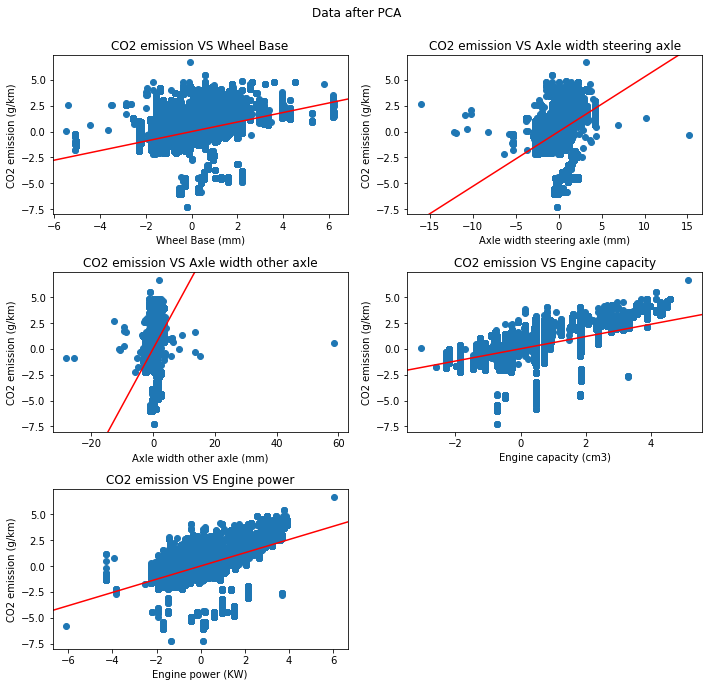

In [24]:
PCA_data.name = 'Data after PCA'
plot_five_features(PCA_data)

In [25]:
polyr = pd.DataFrame()
polyr['y'] = PCA_data.y;polyr['x1'] = PCA_data.x1;polyr['x2'] = PCA_data.x2**2;polyr['x3'] = PCA_data.x3**2;polyr['x4'] = PCA_data.x4;polyr['x5'] = PCA_data.x5
polyr.head()

,y,x1,x2,x3,x4,x5
0,1.078268,2.156390,3.59803,2.170362,0.718846,0.706697
1,1.078268,2.156390,3.59803,2.170362,0.718846,-0.159532
2,1.078268,3.088467,3.59803,2.170362,0.718846,0.706697
3,0.956869,2.156390,3.59803,2.170362,0.718846,0.309845
4,1.615872,2.156390,3.59803,2.170362,0.718846,0.706697


In [26]:
polyr_model = smf.ols(formula='y ~ x1 + x2 + x3 + x4 + x5', data=polyr).fit()
polyr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                 5.776e+04
Date:                Fri, 09 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:47:14   Log-Likelihood:            -3.6118e+05
No. Observations:              327510   AIC:                         7.224e+05
Df Residuals:                  327504   BIC:                         7.224e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0856      0.001    -59.169      0.000      -0.088      -0.083
x1             0.1743      0.002    113.704      0.000       0.171       0.177
x2             0.0850      0.001    121.192      0.000       0.084       0.086
x3             0.0005      0.000      2.644      0.008       0.000       0.001
x4             0.0727      0.002     29.287      0.000       0.068       0.078
x5             0.5150      0.002    217.786      0.000       0.510       0.520
==============================================================================
Omnibus:                   157692.895   Durbin-Watson:                   0.523
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3939974.555
Skew:                          -1.782   Prob(JB):                         0.00
Kurtosis:                      19.614   Cond. No.                         16.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
cross_validation(polyr, 100)

IS R-squared for 100 times is 0.4628278506+-0.002
OS R-squared for 100 times is 0.4630005850+-0.004


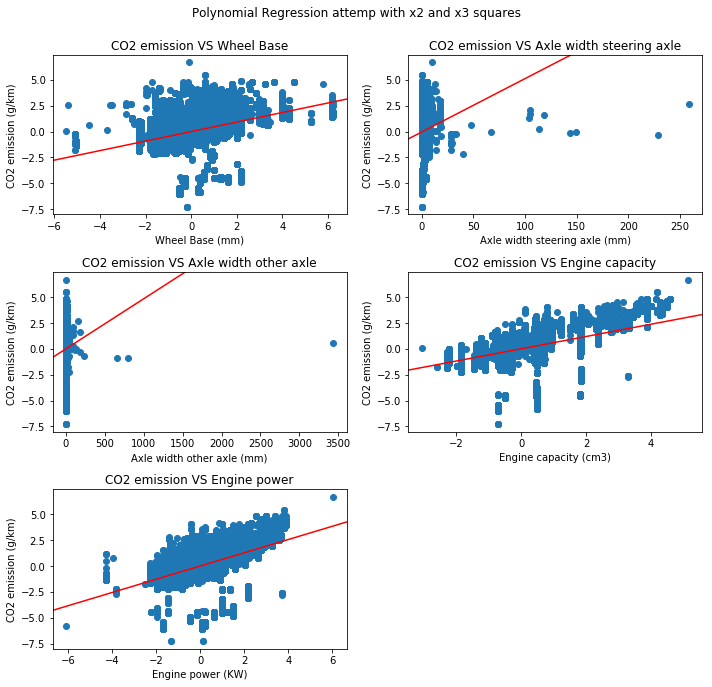

In [28]:
polyr.name = 'Polynomial Regression attemp with x2 and x3 squares'
plot_five_features(polyr)

## Result of raising x2 and x3 to their squares
- the coef for x2 becomes alarmingly smalll
- the coef of x3 increased
- the model is reporting a potential colinearity again
- OS rsquared reduced
- th graphs just look off

# WHAT IF WE MAKE A SQUAREROOT OF IT??

In [29]:
sqrt_polyr = pd.DataFrame()
sqrt_polyr['y'] = PCA_data.y;sqrt_polyr['x1'] = PCA_data.x1;sqrt_polyr['x2'] = PCA_data.x2**(1/2);sqrt_polyr['x3'] = PCA_data.x3**(1/2);sqrt_polyr['x4'] = PCA_data.x4;sqrt_polyr['x5'] = PCA_data.x5
sqrt_polyr.head()

,y,x1,x2,x3,x4,x5
0,1.078268,2.156390,1.377261,1.213761,0.718846,0.706697
1,1.078268,2.156390,1.377261,1.213761,0.718846,-0.159532
2,1.078268,3.088467,1.377261,1.213761,0.718846,0.706697
3,0.956869,2.156390,1.377261,1.213761,0.718846,0.309845
4,1.615872,2.156390,1.377261,1.213761,0.718846,0.706697


In [30]:
sqrt_polyr_model = smf.ols(formula='y ~ x1 + x2 + x3 + x4 + x5', data=sqrt_polyr).fit()
sqrt_polyr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.442
Method:                 Least Squares   F-statistic:                 2.276e+04
Date:                Fri, 09 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:47:31   Log-Likelihood:            -1.6743e+05
No. Observations:              143398   AIC:                         3.349e+05
Df Residuals:                  143392   BIC:                         3.349e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6020      0.006   -105.900      0.000      -0.613      -0.591
x1             0.0822      0.003     27.930      0.000       0.076       0.088
x2            -0.0081      0.011     -0.721      0.471      -0.030       0.014
x3             0.9109      0.011     81.844      0.000       0.889       0.933
x4             0.1485      0.005     32.515      0.000       0.140       0.158
x5             0.3747      0.004     86.591      0.000       0.366       0.383
==============================================================================
Omnibus:                    67715.308   Durbin-Watson:                   0.501
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1024728.421
Skew:                          -1.892   Prob(JB):                         0.00
Kurtosis:                      15.538   Cond. No.                         14.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
sqrt_polyr.dropna(inplace=True)
cross_validation(sqrt_polyr, 100)

IS R-squared for 100 times is 0.3991544597+-0.002
OS R-squared for 100 times is 0.3979700109+-0.005


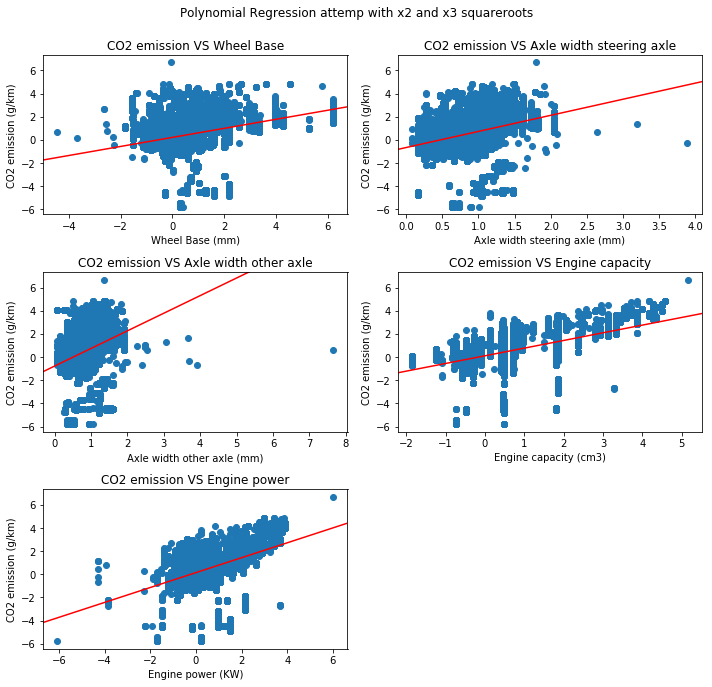

In [32]:
sqrt_polyr.name = 'Polynomial Regression attemp with x2 and x3 squareroots'
plot_five_features(sqrt_polyr)

## Result of sqrt attempt
- model is good
- cross validation is ok
        - r squared decreased in OS
        - not by too much but is this ok?
- the graph shows that x3 is in good shape (relatively)
- BUT HAVE TO DROP NA BEFORE CROSS VALIDATION
    - why does sqrt produce Nan??

# CUT X2 FURTHER 

In [33]:
sqrt_polyr = pd.DataFrame()
sqrt_polyr['y'] = PCA_data.y;sqrt_polyr['x1'] = PCA_data.x1;sqrt_polyr['x2'] = PCA_data.x2**(1/4);sqrt_polyr['x3'] = PCA_data.x3**(1/10);sqrt_polyr['x4'] = PCA_data.x4;sqrt_polyr['x5'] = PCA_data.x5
sqrt_polyr.head()

,y,x1,x2,x3,x4,x5
0,1.078268,2.156390,1.173568,1.039505,0.718846,0.706697
1,1.078268,2.156390,1.173568,1.039505,0.718846,-0.159532
2,1.078268,3.088467,1.173568,1.039505,0.718846,0.706697
3,0.956869,2.156390,1.173568,1.039505,0.718846,0.309845
4,1.615872,2.156390,1.173568,1.039505,0.718846,0.706697


In [34]:
newsqrtp_model = smf.ols(formula='y ~ x1 + x2 + x3 + x4 + x5', data=sqrt_polyr).fit()
newsqrtp_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.444
Model:                            OLS   Adj. R-squared:                  0.444
Method:                 Least Squares   F-statistic:                 2.289e+04
Date:                Fri, 09 Nov 2018   Prob (F-statistic):               0.00
Time:                        17:47:38   Log-Likelihood:            -1.6725e+05
No. Observations:              143398   AIC:                         3.345e+05
Df Residuals:                  143392   BIC:                         3.346e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.8712      0.025   -116.026      0.000      -2.920      -2.823
x1             0.1135      0.003     40.151      0.000       0.108       0.119
x2            -0.0245      0.017     -1.458      0.145      -0.057       0.008
x3             3.1788      0.035     91.211      0.000       3.110       3.247
x4             0.1779      0.005     39.283      0.000       0.169       0.187
x5             0.3708      0.004     85.646      0.000       0.362       0.379
==============================================================================
Omnibus:                    66406.172   Durbin-Watson:                   0.499
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           951957.068
Skew:                          -1.861   Prob(JB):                         0.00
Kurtosis:                      15.061   Cond. No.                         43.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
sqrt_polyr.dropna(inplace=True)
cross_validation(sqrt_polyr, 100)

IS R-squared for 100 times is 0.3919445836+-0.002
OS R-squared for 100 times is 0.3908288987+-0.005


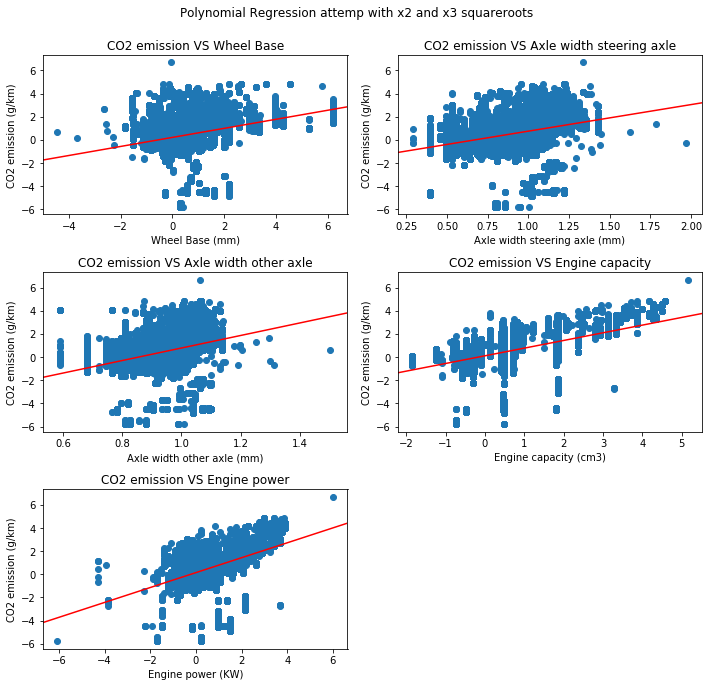

In [36]:
sqrt_polyr.name = 'Polynomial Regression attemp with x2 and x3 squareroots'
plot_five_features(sqrt_polyr)

# LOOKING GOOD?

## Find correct features and make predictions with it

# Compare Plots

In [37]:
d1 = pd.DataFrame()
d1 = mulr
d1.name = "Original Data"
d2 = pd.DataFrame(scaled_data, index=mulr.index, columns=mulr.columns)
d2.name = "Standarized Data"
d3 = pd.DataFrame()
d3 = PCA_data
d3.name = "Data after 6 PCA"
#========================================================================
pca = PCA(5, whiten=True, random_state=rndseed) 
d4 = d2.drop('y', axis=1)
pca.fit(d4); P=pca.transform(d4)
temp = pd.DataFrame(P)
d4 = pd.DataFrame()
d4['y'] = d2.y; d4['x1'] = temp[0]; d4['x2'] = temp[1]; d4['x3'] = temp[2]; d4['x4'] = temp[3]; d4['x5'] = temp[4]
d4.name = "5 PCA without y"

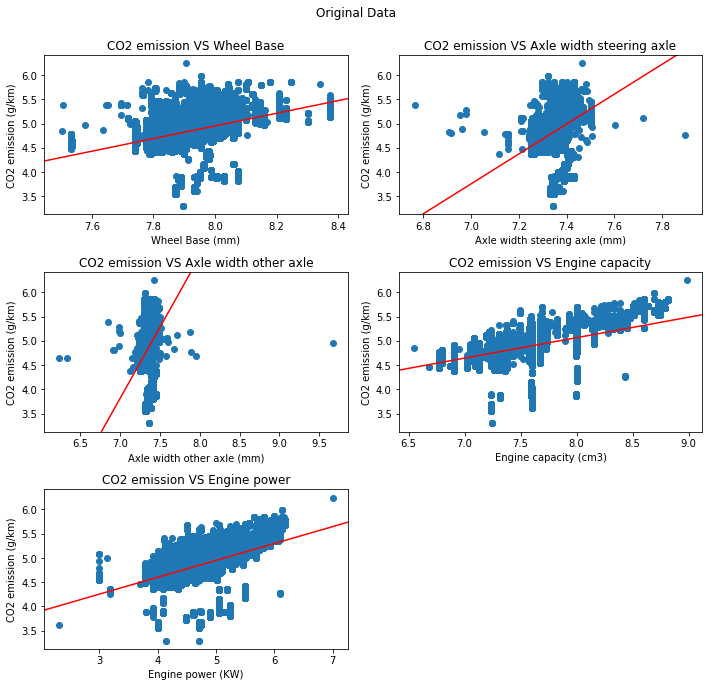

In [38]:
plot_five_features(d1)

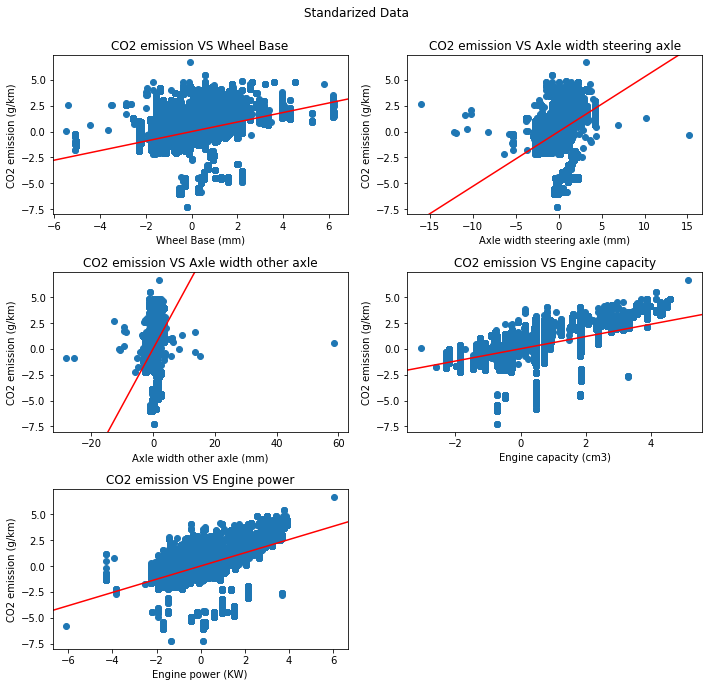

In [39]:
plot_five_features(d2)

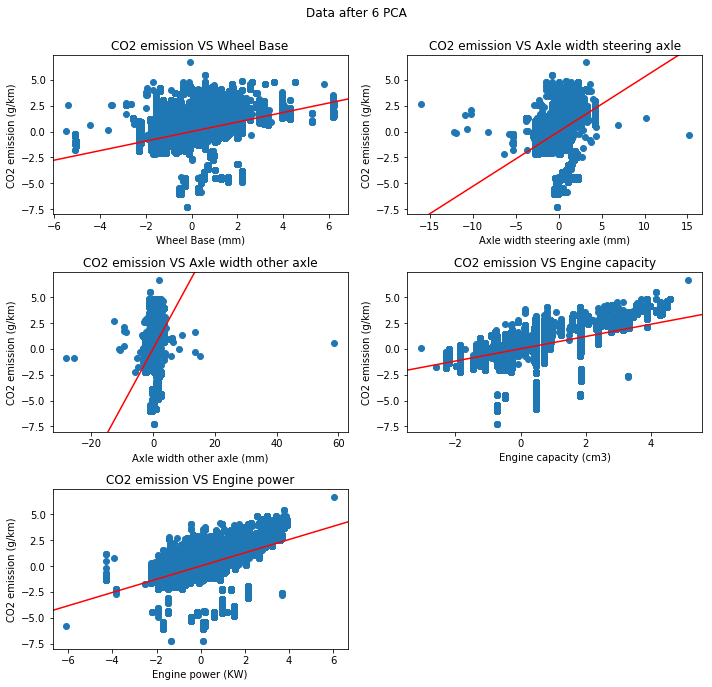

In [40]:
plot_five_features(d3)

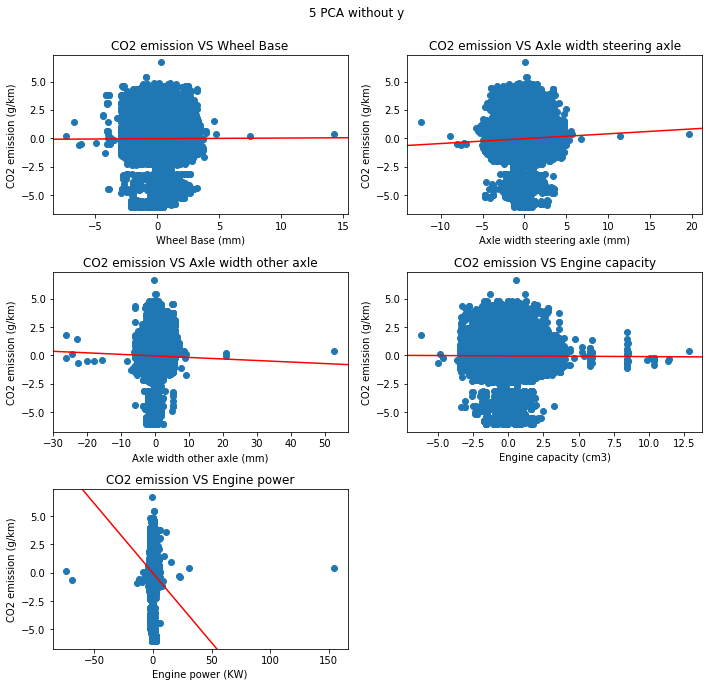

In [41]:
plot_five_features(d4)

1. how can x2 and x3 be better described, they dont appear to have a linear relationship to y
    - exlude them?
    - throw them into the epsilon factor? (how?)
    
2. should PCA include y?
    - and whats up with the train test split before the pca?
    
3. when to use pca(0.8) and when to use pca(3)?

4. from cross validation, the model performs equally well in and out sample, does that mean the model is good?
    - only one year worth of data is used, should more years be included?